In [57]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy')

Text(0, 0.5, 'lat [$^\\circ$]')

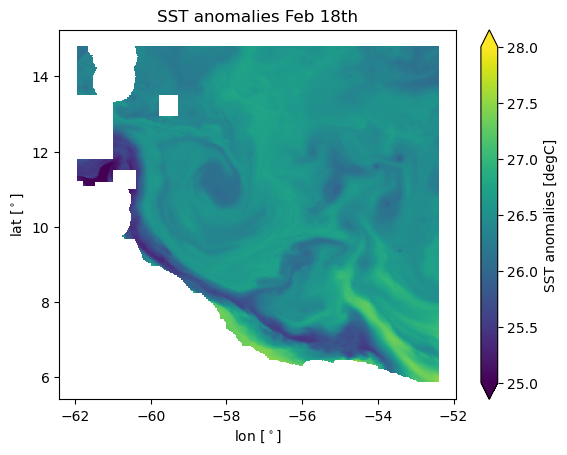

In [8]:

plt.pcolormesh(lon_M, lat_M, sst_day[1,:,:]-273.15, vmin=25, vmax=28, cmap='viridis')
plt.colorbar(extend='both', label='SST anomalies [degC]')
plt.title(f'SST anomalies Feb 18th')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')

In [5]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask, drop=False)
pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300. 

pot_temp_full = pot_temp+T0

In [6]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
GPH = GPH['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [7]:
GPH_mean = GPH.mean(axis=(0,2,3))

In [8]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(pot_temp)
for i in range(39):
    GPH_inter[:,i,:,:] = (GPH[:,i+1,:,:]+GPH[:,i,:,:])*0.5

In [9]:
# CALCULATE BRUNT VAISALA
BV_freq = mpcalc.brunt_vaisala_frequency_squared(GPH_inter*units.meters, pot_temp_full.values*units.kelvin, vertical_dim = 1)

In [ ]:
# retrieve SST, temperature, "buoyancy" and PBLH

In [5]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [6]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [7]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask, drop=False).values; 

In [7]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask, drop=False).values

In [8]:
buoya = sst_day - T2

In [10]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()            
PBLH_day = PBLH_day.where(sea_mask, drop=False).values; 

In [48]:
buoya_flat = buoya[~np.isnan(buoya)].flatten()
#buoya_flat = np.sort(buoya_flat)
perc_99 = np.percentile(buoya_flat, 99); print(f'perc 99 = {perc_99}')
perc_95 = np.percentile(buoya_flat, 95); print(f'perc 95 = {perc_95}')
perc_75 = np.percentile(buoya_flat, 75); print(f'perc 75 = {perc_75}')
perc_3_5 = np.percentile(buoya_flat, 3.5); print(f'perc 3.5 = {perc_3_5}')

perc 99 = 1.313720703125
perc 95 = 1.12005615234375
perc 75 = 0.870086669921875
perc 3.5 = -0.00152587890625


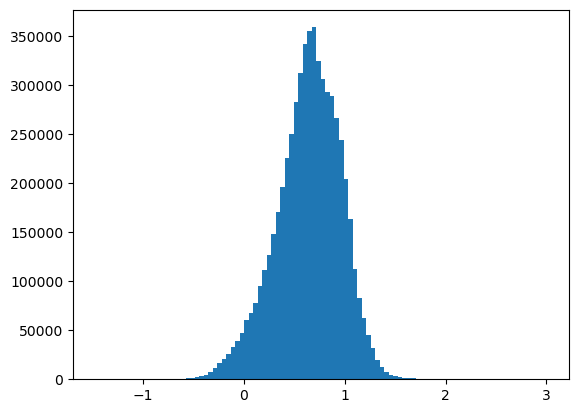

In [46]:
res= plt.hist(buoya_flat[buoya_flat<3], bins=100)
freq = res[0]/(len(buoya_flat[buoya_flat<3]))
bin_ave = 0.5*(res[1][0:-1]+res[1][1:])

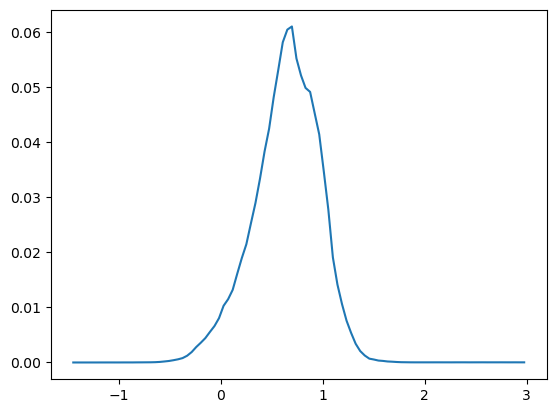

In [47]:
plt.plot(bin_ave, freq)

In [15]:
# compute anomalies daily data
s = 100

# I want ot concentrate on heat fluxes now
# whenever want to do statistics on BV
# TURN THIS TRUE
bv = False

dsst_day = np.zeros(sst_day.shape)
'''dbuoya_day = np.zeros(buoya.shape)'''
'''dPBLH_day = np.zeros(PBLH_day.shape)'''

if bv:
    dBV_freq_day = np.zeros(BV_freq.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    '''buoya_ave = gm.nan_gaussian_filter(buoya[t],s)                             
    dbuoya_day[t] = buoya[t] - buoya_ave'''
    
    '''pbl_ave = gm.nan_gaussian_filter(PBLH_day[t],s)                             
    dPBLH_day[t] = PBLH_day[t] - pbl_ave'''
    
    if bv:
        for h in range(0,BV_freq.shape[1]):
            bv_ave = gm.nan_gaussian_filter(BV_freq[t,h].magnitude,s)                               
            dBV_freq_day[t,h] = BV_freq[t,h].magnitude - bv_ave

0
10
20


In [67]:
my_save_data('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', dsst_day)

In [14]:
##### OTHERWISE LOAD THEM FROM THE FILES  ######
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

# with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:
#     dPBLH_day = np.load(f)

In [26]:
# compute distributions

(29, 546, 573)

In [8]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [18]:
# PERC DISTRIBUTION dBV_fre vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst_day, pdist_dBV_freq_day, pstd_dBV_freq_day, pstderr_dBV_freq_day, pnpoints_dBV_freq_day, ppvalue_dBV_freq_day_sub = \
dist_3d_subsample(dsst_day, dBV_freq_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [22]:
# PERC DISTRIBUTION BV_fre vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst_day, pdist_BV_freq, pstd_BV_freq, pstderr_BV_freq, pnpoints_BV_freq, ppvalue_BV_freq_sub = \
dist_3d_subsample(dsst_day, BV_freq.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0


KeyboardInterrupt: 

In [ ]:
# FIXED BIN DISTRIBUTIONS

In [19]:
# FB DISTRIBUTION dBV_freq vs dSST bin - DAILY + PVALUE subsampled

perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

dist_dsst_day, dist_dBV_freq_day, std_dBV_freq_day, stderr_dBV_freq_day, npoints_dBV_freq_day, pvalue_dBV_freq_day_sub = \
dist_3d_subsample(dsst_day, dBV_freq_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')

0
10
20
30


In [104]:
# FB DISTRIBUTION BV vs dSST bin - DAILY + PVALUE subsampled
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

dist_dsst_day, dist_BV_freq, std_BV_freq, stderr_BV_freq, npoints_BV_freq, pvalue_BV_freq_sub = \
dist_3d_subsample(dsst_day, BV_freq.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, 'fb')

0
10
20
30


In [24]:
data

memmap([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.55837683e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.95420577e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.000000

In [47]:
# save distributions data
perc = True


path_to_data = '/venus/tesi_ale/results_EU/distributions/FEB/'
filename = path_to_data + 'perc/BV/' if perc else path_to_data + 'fix_bin/BV/'

x_perc = [pdist_dsst_day, pdist_dBV_freq_day, pstd_dBV_freq_day, pstderr_dBV_freq_day, pnpoints_dBV_freq_day, ppvalue_dBV_freq_day_sub]
x_bins = [dist_dsst_day, dist_dBV_freq_day, std_dBV_freq_day, stderr_dBV_freq_day, npoints_dBV_freq_day, pvalue_dBV_freq_day_sub]

filename += 'pdist_dBV_dsst_day_feb.npy' if perc else 'dist_dBV_dsst_day_feb.npy'


# CHECK IF FILE ALREADY EXISTS - DELETE IF SO
if os.path.exists(filename):
    print('file already exists - DELETING IT')
    os.remove(filename)

if perc:
    #my_save_data(filename, x_perc)
else:
    #my_save_data(filename, x_bins)
    
del filename

file already exists - DELETING IT


In [ ]:
# correlations with PBLH

In [26]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [27]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask, drop=False).values;

In [28]:
dPBLH_day = np.zeros(PBLH_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    PBLH_ave = gm.nan_gaussian_filter(PBLH_day[t],s)
    dPBLH_day[t] = PBLH_day[t] - PBLH_ave

0
10
20


In [20]:
# PERC DISTRIBUTION    +   
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

# # dPBLH vs dSST - DAILY
# pdist_dsst_day, pdist_dPBLH_day, pstd_dPBLH_day, pstderr_dPBLH_day, pnpoints_dPBLH_day, ppvalue_dPBLH_day = \
# distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, 'perc')

# dSST vs PBLH 
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')


In [21]:
# FB DISTRIBUTION dPBLH vs dSST bin - DAILY 
perc_step = 5
nbins = int(100/perc_step) # Number of bins.


# # dPBLH vs dSST - DAILY
# dist_dsst_day, dist_dPBLH_day, std_dPBLH_day, stderr_dPBLH_day, pvalue_dPBLH_day = \
# distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, 'fb')

# dSST vs PBLH 
dist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, npoints_PBLH_dsst, pvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')


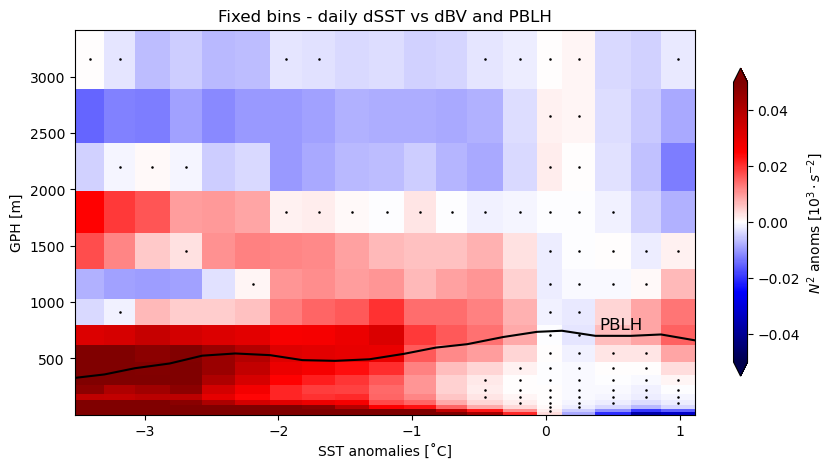

In [50]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(18)

perc = False
x = pdist_dsst_day if perc else dist_dsst_day
var = pdist_dBV_freq_day[0:p_level_plot,:]*1000 if perc else dist_dBV_freq_day[0:p_level_plot,:]*1000
minval = -0.025 if perc else -0.05
maxval = -minval
title = 'Percentiles' if perc else 'Fixed bins'

fig, ax1 = plt.subplots(figsize=(10, 5))  
p1 = ax1.pcolormesh(x, GPH_mean[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic') #pdist_dqvapor_dsst_day
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('GPH [m]')
plt.title(f'{title} - daily dSST vs dBV and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('$N^2$ anoms [$10^3 \cdot s^{-2}$]')


x_pbl = pdist_dsst if perc else dist_dsst
var_pbl = pdist_PBLH_dsst if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
ax1.text(0.4, 755, 'PBLH', fontsize=12)



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dBV_freq_day_sub[0:p_level_plot] if perc else pvalue_dBV_freq_day_sub[0:p_level_plot]
GPbin = GPH_mean[1:p_level_plot] - np.diff(GPH_mean[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(GPH_mean[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(GPH_mean[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(GPH_mean[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


path_img = '/venus/tesi_ale/img_EU/BV/daily/distrib/perc/FEB/' if perc else '/venus/tesi_ale/img_EU/BV/daily/distrib/fix_bin/FEB/'
filename = path_img + 'pdist_dsst_dBV_lowtropo.png' if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
#plt.savefig(filename)
#print(filename)
del filename

In [18]:
#########    LOAD SST AND PBLH DISTRIBUTIONS  ########
with open('/venus/tesi_ale/results_EU/distributions/FEB/perc/PBLH/pdistrs_dPBLH_dsst_day_feb.npy', 'rb') as f:
    pdist_dsst       = np.load(f, allow_pickle=True)
    pdist_dPBLH_dsst = np.load(f, allow_pickle=True)
    pstd_PBLH_dsst   = np.load(f, allow_pickle=True)

with open('/venus/tesi_ale/results_EU/distributions/FEB/fix_bin/PBLH/distrs_dPBLH_dsst_day_feb.npy', 'rb') as f:
    dist_dsst       = np.load(f, allow_pickle=True)
    dist_dPBLH_dsst = np.load(f, allow_pickle=True)
    std_PBLH_dsst   = np.load(f, allow_pickle=True)


OSError: Failed to interpret file <_io.BufferedReader name='/venus/tesi_ale/results_EU/distributions/FEB/perc/PBLH/pdistrs_dPBLH_dsst_day_feb.npy'> as a pickle

In [12]:
np.nanmax(pstd_PBLH_dsst)

0.1445503341416252

In [ ]:
#######   SEE BEHAVIOUR OF SURFACE HEAT FLUXES

In [9]:
LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
LH = LH.where(sea_mask, drop=False).values; 

HFX = ds_hourly['HFX'].groupby('time_counter.day').mean()            
HFX = HFX.where(sea_mask, drop=False).values; 

In [14]:
# this should be the Bowen ratio at the surface
heat_ratio = LH/HFX
heat_ratio[HFX==0] = 999.

In [ ]:
# heat anomalies

In [10]:
s = 100

dLH = np.zeros(LH.shape)
dHFX = np.zeros(HFX.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_ave = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_ave
    
    HFX_ave = gm.nan_gaussian_filter(HFX[t],s)                             
    dHFX[t] = HFX[t] - HFX_ave

0
10
20


In [66]:
my_save_data('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', dLH)
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', dHFX)

In [ ]:
# DISTRIBUTIONS

In [11]:
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [ ]:
# visualizing 

In [ ]:
# dSST vs dLH / dHFX vs PBLH

In [ ]:
#########    LH     #########

In [62]:
# dSST vs dLH
pdist_x, pdist_dLH, pstd_dLH, pstderr_dLH, pnpoints_dLH, ppvalue_dLH =   distrib_2d(dsst_day, dLH, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dLH, std_dLH, stderr_dLH, npoints_dLH, pvalue_dLH       =   distrib_2d(dsst_day, dLH, perc_step, nbins, popmean, perc_fixbin='fb')

In [17]:
# SST vs LH
pdist_sst, pdist_LH, pstd_LH, pstderr_LH, pnpoints_LH, ppvalue_LH =   distrib_2d(sst_day, LH, perc_step, nbins, popmean, perc_fixbin='perc')
dist_sst, dist_LH, std_LH, stderr_LH, npoints_LH, pvalue_LH       =   distrib_2d(sst_day, LH, perc_step, nbins, popmean, perc_fixbin='fb')

In [65]:
# save distributions data - DONE
'''p_dsst = [pdist_x, pdist_dLH, pstd_dLH, pnpoints_dLH]
my_save_data('/venus/tesi_ale/data_EU/LH/daily/FEB/pdist_dsst_dLH_day_feb.npy', p_dsst)'''

file already exists - DELETING IT


/venus/tesi_ale/img_EU/LH/daily/FEBscatterFIT_dsst_dLH_feb.png


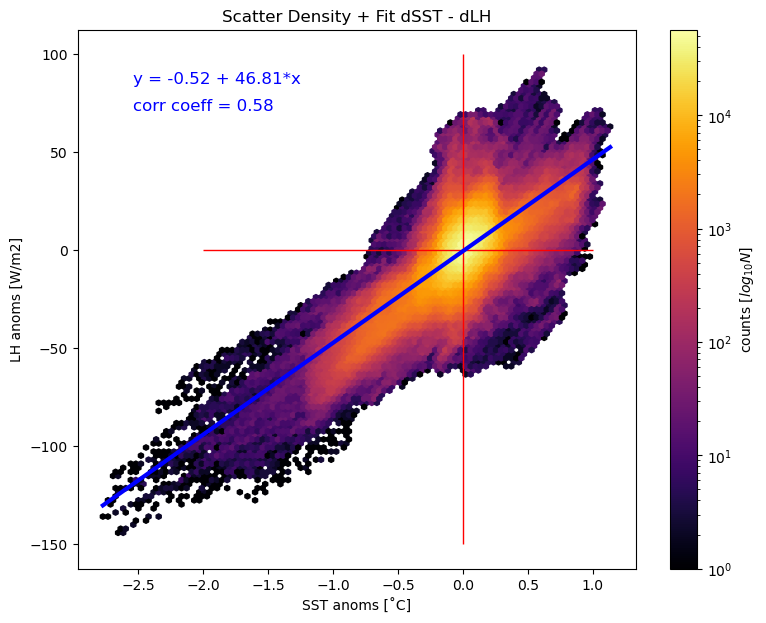

In [85]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = True

if not dsst:
    x = (sst_day[~np.isnan(sst_day)]-273.15).copy()       #[::nt,::nskip,::nskip].copy()
    y = LH[~np.isnan(LH)].copy()
    fit, corcoe, p_value = slopes_r_p(x,y)
    title=' Scatter Density + Fit SST - LH'
    xlabel='SST [˚C]'
    ylabel='LH [W/m2]'
    
else:
    x = dsst_day[~np.isnan(dsst_day)].copy()       #[::nt,::nskip,::nskip].copy()
    y = dLH[~np.isnan(dLH)].copy()
    fit, corcoe, p_value = slopes_r_p(x,y)
    title='Scatter Density + Fit dSST - dLH'
    xlabel='SST anoms [˚C]'
    ylabel='LH anoms [W/m2]'
    miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1
    

fig = density_hexbin(x,y,fit=fit,corcoe=corcoe,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')
     
'''fig = plt.figure(figsize=(10,7))reens', mincnt=1)
plt.colorbar(label='counts [$log_{10}N$]')
xx = np.linspace(x.min(), x.max(), 5)
plt.plot(xx, fit.slope*xx+fit.intercept, '-b', linewidth=3)
plt.annotate('y = '+str(round(fit.intercept,2))+ ' + ' + str(round(fit.slope,2))+'*x' , xy=(0.1, 0.9), \
                     xycoords='axes fraction', fontsize=12, color='blue')    

plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='blue')'''

#scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)

if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    



path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB' 
filename = path_img + 'scatterFIT_dsst_dLH_feb.png' if dsst else path_img + 'scatterFIT_sst_LH_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [86]:
p_value

0.0

In [ ]:
#########    HFX     #########

In [68]:
# dSST vs dHFX
pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX =   distrib_2d(dsst_day, dHFX, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dHFX, std_dHFX, stderr_dHFX, npoints_dHFX, pvalue_dHFX       =   distrib_2d(dsst_day, dHFX, perc_step, nbins, popmean, perc_fixbin='fb')

In [69]:
# SST vs HFX
pdist_sst, pdist_HFX, pstd_HFX, pstderr_HFX, pnpoints_HFX, ppvalue_HFX =   distrib_2d(sst_day, HFX, perc_step, nbins, popmean, perc_fixbin='perc')
dist_sst, dist_HFX, std_HFX, stderr_HFX, npoints_HFX, pvalue_HFX       =   distrib_2d(sst_day, HFX, perc_step, nbins, popmean, perc_fixbin='fb')

In [72]:
'''p_sst = [pdist_sst, pdist_HFX, pstd_HFX, pnpoints_HFX]
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/pdist_sst_HFX_day_feb.npy', p_sst)'''

/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_sst_HFX_feb.png


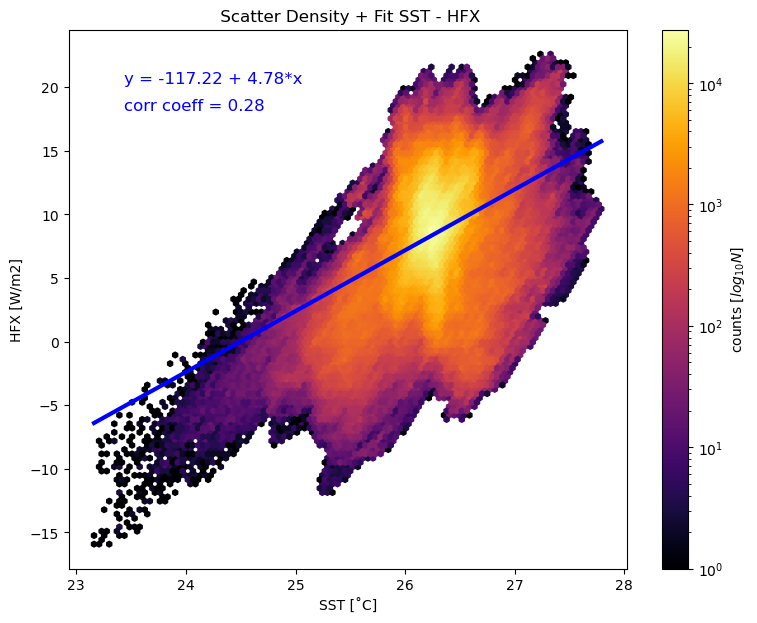

In [84]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = False

if not dsst:
    x = (sst_day-273.15).copy()       #[::nt,::nskip,::nskip].copy()
    y = HFX.copy()
    fit, corcoe, p_value = slopes_r_p(x,y)
    title=' Scatter Density + Fit SST - HFX'
    xlabel='SST [˚C]'
    ylabel='HFX [W/m2]'
else:
    x = dsst_day.copy()       #[::nt,::nskip,::nskip].copy()
    y = dHFX.copy()
    fit, corcoe, p_value = slopes_r_p(x,y)
    title='Scatter Density + Fit dSST - dHFX'
    xlabel='SST anoms [˚C]'
    ylabel='HFX anoms [W/m2]'
    miny = -20 ; maxy = -miny
    minx = -2 ; maxx = 1


fig = density_hexbin(x,y,fit=fit,corcoe=corcoe,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')
    
    
'''fig1 = scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)
plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='orange')'''
if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
    

    


path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dHFX_feb.png' if dsst else path_img + 'scatterFIT_sst_HFX_feb.png'
plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    PBLH     #########

In [42]:
# dSST vs dPBLH
pdist_x, pdist_dPBLH, pstd_dPBLH, pstderr_dPBLH, pnpoints_dPBLH, ppvalue_dPBLH =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dPBLH, std_dPBLH, stderr_dPBLH, npoints_dPBLH, pvalue_dPBLH       =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')


In [45]:
# dSST vs PBLH
pdist_x, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_PBLH, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH       =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')

In [ ]:
#### PLOTTING

/venus/tesi_ale/img_EU/LH/daily/FEB/scatterFIT_sst_LH_distribs.png


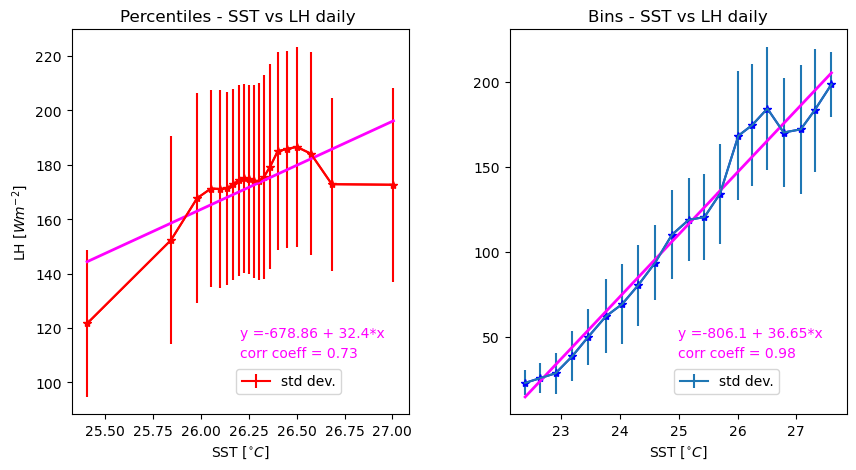

In [68]:
# dist_x vs dLH

full = True



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

title = 'SST vs LH daily' if full else 'dSST vs dLH daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'LH [$Wm^{-2}$]' if full else 'dLH [$Wm^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_LH if full else pdist_dLH
stderr_p = pstd_LH if full else pstd_dLH

fit_p, corcoe_p, p_value_p = slopes_r_p(x_p,var_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p.slope*x_p + fit_p.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=stderr_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p.intercept, 2)) + ' + ' + str(round(fit_p.slope, 2)) + '*x', xy=(0.5, 0.2), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p,2)), xy=(0.5, 0.15), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='lower right', bbox_to_anchor=(0.82, 0.035))


##############################

x_fb = dist_sst-273.15 if full else dist_x 
var_fb = dist_LH if full else dist_dLH
stderr_fb = std_LH if full else std_dLH

fit_fb, corcoe_fb, p_value_fb = slopes_r_p(x_fb,var_fb)

p2 = ax2.plot(x_fb, var_fb, '*-b')
ax2.plot(x_fb, fit_fb.slope*x_fb + fit_fb.intercept, color='magenta', linewidth=2)
ax2.errorbar(x_fb, var_fb, yerr=stderr_fb, xerr=None, label='std dev.')
ax2.set_xlabel(xlabel)
ax2.set_title(f'Bins - {title}'); # ax2.grid()

ax2.annotate('y =' + str(round(fit_fb.intercept, 2)) + ' + ' + str(round(fit_fb.slope, 2)) + '*x', xy=(0.5, 0.2), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax2.annotate('corr coeff = '+str(round(corcoe_fb,2)), xy=(0.5, 0.15), \
                     xycoords='axes fraction', fontsize=10, color='magenta')

ax2.legend(loc='lower right', bbox_to_anchor=(0.82, 0.035))

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)



path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_LH_distribs.png' if full else path_img + 'scatterFIT_dsst_dLH_distribs.png'
#plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_dsst_dHFX_distribs.png


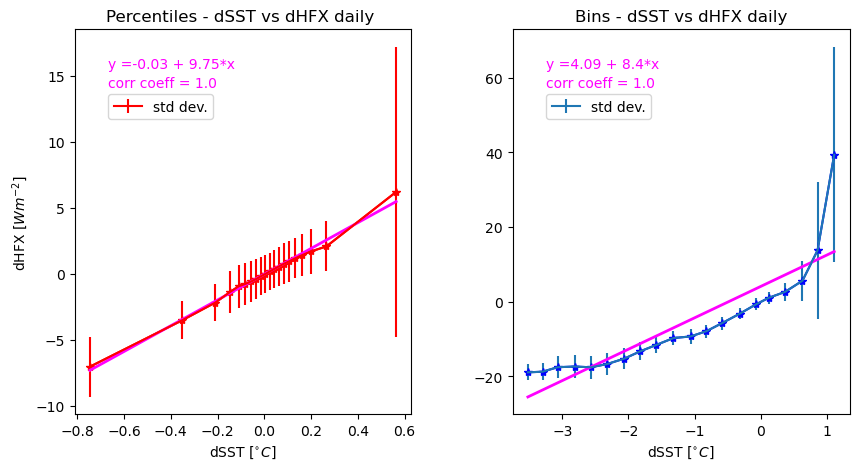

In [16]:
# dist_x vs dHFX

full = False



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


title = 'SST vs HFX daily' if full else 'dSST vs dHFX daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'HFX [$Wm^{-2}$]' if full else 'dHFX [$Wm^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_HFX if full else pdist_dHFX

stderr_p = pstd_HFX if full else pstd_dHFX
fit_p, corcoe_p, p_value_p = slopes_r_p(x_p,var_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p.slope*x_p + fit_p.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=stderr_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p.intercept, 2)) + ' + ' + str(round(fit_p.slope, 2)) + '*x', xy=(0.1, 0.9), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='upper left', bbox_to_anchor=(0.08, 0.85))


##############################

x_fb = dist_sst-273.15 if full else dist_x 
var_fb = dist_HFX if full else dist_dHFX

stderr_fb = std_HFX if full else std_dHFX
fit_fb, corcoe_fb, p_value_fb = slopes_r_p(x_fb,var_fb)

p2 = ax2.plot(x_fb, var_fb, '*-b')
ax2.plot(x_fb, fit_fb.slope*x_fb + fit_fb.intercept, color='magenta', linewidth=2)
ax2.errorbar(x_fb, var_fb, yerr=stderr_fb, xerr=None, label='std dev.')
ax2.set_xlabel(xlabel)
ax2.set_title(f'Bins - {title}'); # ax2.grid()

ax2.annotate('y =' + str(round(fit_fb.intercept, 2)) + ' + ' + str(round(fit_fb.slope, 2)) + '*x', xy=(0.1, 0.9), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax2.annotate('corr coeff = '+str(round(corcoe_fb,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=10, color='magenta')

ax2.legend(loc='upper left', bbox_to_anchor=(0.08, 0.85))

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)





path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_HFX_distribs.png' if full else path_img + 'scatterFIT_dsst_dHFX_distribs.png'
#plt.savefig(filename)
print(filename)
del filename

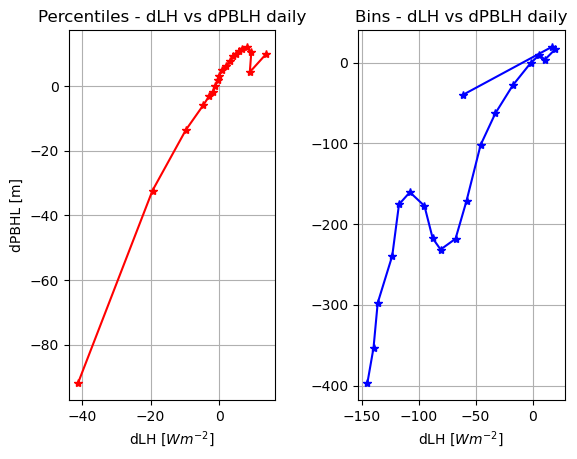

In [43]:
# dLH vs dPBLH

fig, (ax1, ax2) = plt.subplots(1, 2)

p1 = ax1.plot(pdist_dLH, pdist_dPBLH, '*-r')
ax1.set_xlabel('dLH [$Wm^{-2}$]')
ax1.set_ylabel('dPBHL [m]')
ax1.set_title('Percentiles - dLH vs dPBLH daily'); ax1.grid()

p2 = ax2.plot(dist_dLH, dist_dPBLH, '*-b')
ax2.set_xlabel('dLH [$Wm^{-2}$]')
ax2.set_title('Bins - dLH vs dPBLH daily'); ax2.grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)

In [ ]:
#############    THERMODYNAMIC CONTRIBUTION TO dLH/dSST?

q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day.where(sea_mask, drop=False).values;

In [ ]:
# retrieving pressure field

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']
# pres_base = pres_base[0,:,:]

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')]);  pres = pres['P']
pres = pres.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pres = (pres+pres_base)/100.
#pres = pres.groupby('time_counter.day').mean()


pres = pres.where(sea_mask, drop=False)


del pres_base

In [ ]:
# retrieving pressure at surface level
pres_sfc = pres[:,0,:,:]
#pres_sfc = pres_sfc.where(sea_mask, drop=False)
pres_sfc = pres_sfc.groupby('time_counter.day').mean()

In [ ]:
## compute saturation vapour pressure

In [ ]:
qsat = mpcalc.saturation_mixing_ratio(pres_sfc*units.hPa,T2_day*units.K).to('g/kg')
delta_q = qsat-q2_day*units('kg/kg')

In [ ]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = False

if not dsst:
    x = (sst_day-273.15).copy()       #[::nt,::nskip,::nskip].copy()
    y = delta_q.copy()
    fit, corcoe, p_value = slopes_r_p(x,y)
    title=' Scatter + Fit SST - Δq'
    xlabel='SST [˚C]'
    ylabel='Δq [W/m2]'
'''else:
    x = dsst_day.copy()       #[::nt,::nskip,::nskip].copy()
    y = dLH.copy()
    fit, corcoe, p_value = slopes_r_p(x,y)
    title='Scatter + Fit dSST - d Δq'
    xlabel='SST anoms [˚C]'
    ylabel='Δq anoms [W/m2]'
    miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1'''

fig = plt.figure(figsize=(10,7))
scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)
plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='orange')
'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
    

    


path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dLH_feb.png' if dsst else path_img + 'scatterFIT_sst_LH_feb.png'
#plt.savefig(filename)
print(filename)
del filename